In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
fl_inflow_origin_2122 = pd.read_excel("2122fl.xlsx", sheet_name="County Inflow", usecols="C:F", skiprows=5)
fl_inflow_origin_2122.columns = ["state_code", "county_code", "state", "county_name"]

fl_inflow_counts_2122 = pd.read_excel("2122fl.xlsx", sheet_name="County Inflow", usecols="G:I", skiprows=5)
fl_inflow_counts_2122.columns = ["number_of_returns", "number_of_individuals", "AGI"]

In [3]:
fl_inflow_origin_1718 = pd.read_excel("1718fl.xls", sheet_name="County Inflow", usecols="C:F", skiprows=5)
fl_inflow_origin_1718.columns = ["state_code", "county_code", "state", "county_name"]

fl_inflow_counts_1718 = pd.read_excel("1718fl.xls", sheet_name="County Inflow", usecols="G:I", skiprows=5)
fl_inflow_counts_1718.columns = ["number_of_returns", "number_of_individuals", "AGI"]

In [4]:
fl_inflow_2122 = pd.concat([fl_inflow_origin_2122, fl_inflow_counts_2122], axis=1)
fl_inflow_1718 = pd.concat([fl_inflow_origin_1718, fl_inflow_counts_1718], axis=1)
fl_inflow_2122.dropna(inplace= True)
fl_inflow_1718.dropna(inplace= True)

In [5]:
def prepare_migration_data(df, total_label="Total Migration-US", non_label="Non-migrants"):
    # Total US migration
    total_us = df[df["county_name"].str.endswith(total_label)].copy()
    total_us["county_name"] = total_us["county_name"].str.extract(r"^(.+?) County")[0]
    total_us = total_us[["county_name", "number_of_individuals"]].rename(
        columns={"number_of_individuals": "total_migration"}
    )
    
    # Non-migrants
    non = df[df["county_name"].str.contains(non_label, case=False, na=False)].copy()
    non["county_name"] = non["county_name"].str.extract(r"^(.+?) County")[0]
    non = non[["county_name", "county_code", "number_of_individuals"]].rename(
        columns={"number_of_individuals": "non_migrants"}
    )
    
    # Merge
    final_df = pd.merge(non, total_us, on="county_name", how="inner")
    
    return final_df[["county_name", "county_code", "total_migration", "non_migrants"]]


In [6]:
df_1718 = prepare_migration_data(fl_inflow_1718)
df_2122 = prepare_migration_data(fl_inflow_2122)

df_1718.rename(columns={
    "total_migration": "total_migration_1718",
    "non_migrants": "non_migrants_1718"
}, inplace=True)

df_2122.rename(columns={
    "total_migration": "total_migration_2122",
    "non_migrants": "non_migrants_2122"
}, inplace=True)


In [7]:
cdc_data_22 = pd.read_csv('500_cities_data_22.csv')
cdc_data_18 = pd.read_csv('500_cities_data_18.csv')

cdc_fl_22 = cdc_data_22[cdc_data_22["StateDesc"].str.contains("Florida", case=False, na=False)].copy()
cdc_fl_18 = cdc_data_18[cdc_data_18["StateDesc"].str.contains("Florida", case=False, na=False)].copy()

mental_health_18 = cdc_fl_18.groupby("CountyName")["MHLTH_CrudePrev"].mean().reset_index()
mental_health_18.rename(columns={"MHLTH_CrudePrev": "mental_health_18"}, inplace=True)

mental_health_22 = cdc_fl_22.groupby("CountyName")["MHLTH_CrudePrev"].mean().reset_index()
mental_health_22.rename(columns={"MHLTH_CrudePrev": "mental_health_22"}, inplace=True)


In [8]:
merged_df_1718 = pd.merge(df_1718, mental_health_18, left_on="county_name", right_on="CountyName", how="inner")
merged_df_1718.drop(columns=["CountyName"], inplace=True)

merged_df_2122 = pd.merge(df_2122, mental_health_22, left_on="county_name", right_on="CountyName", how="inner")
merged_df_2122.drop(columns=["CountyName"], inplace=True)

merged_all_years = pd.merge(
    merged_df_1718, 
    merged_df_2122, 
    on=["county_name", "county_code"], 
    how="outer"
)

In [9]:
merged_all_years.columns

Index(['county_name', 'county_code', 'total_migration_1718',
       'non_migrants_1718', 'mental_health_18', 'total_migration_2122',
       'non_migrants_2122', 'mental_health_22'],
      dtype='object')

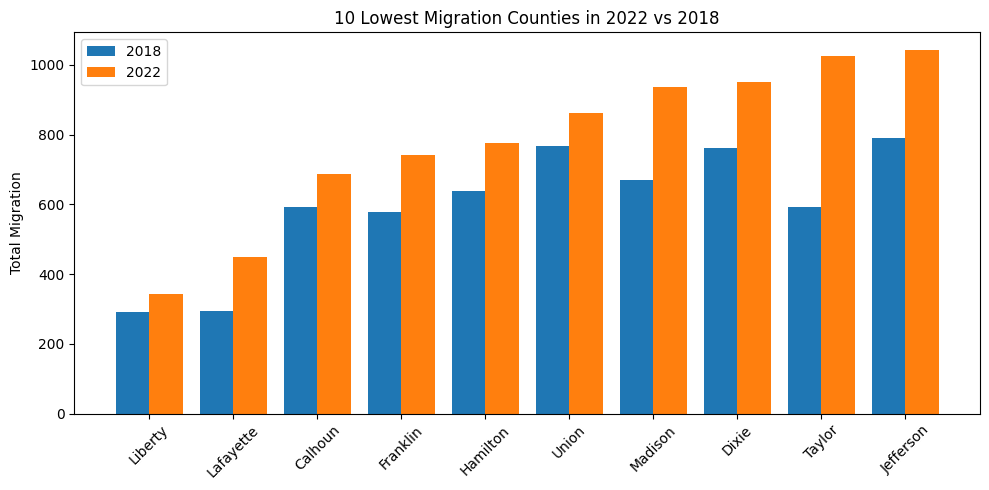

In [10]:
for col in ["total_migration_1718", "total_migration_2122"]:
    merged_all_years[col] = pd.to_numeric(merged_all_years[col], errors="coerce")

# Pick 10 counties with lowest migration in 2022
lowest_2022 = merged_all_years.nsmallest(10, "total_migration_2122")

x = range(len(lowest_2022))
plt.figure(figsize=(10,5))
plt.bar(x, lowest_2022["total_migration_1718"], width=0.4, label="2018")
plt.bar([i+0.4 for i in x], lowest_2022["total_migration_2122"], width=0.4, label="2022")
plt.xticks([i+0.2 for i in x], lowest_2022["county_name"], rotation=45)
plt.ylabel("Total Migration")
plt.title("10 Lowest Migration Counties in 2022 vs 2018")
plt.legend()
plt.tight_layout()
plt.show()


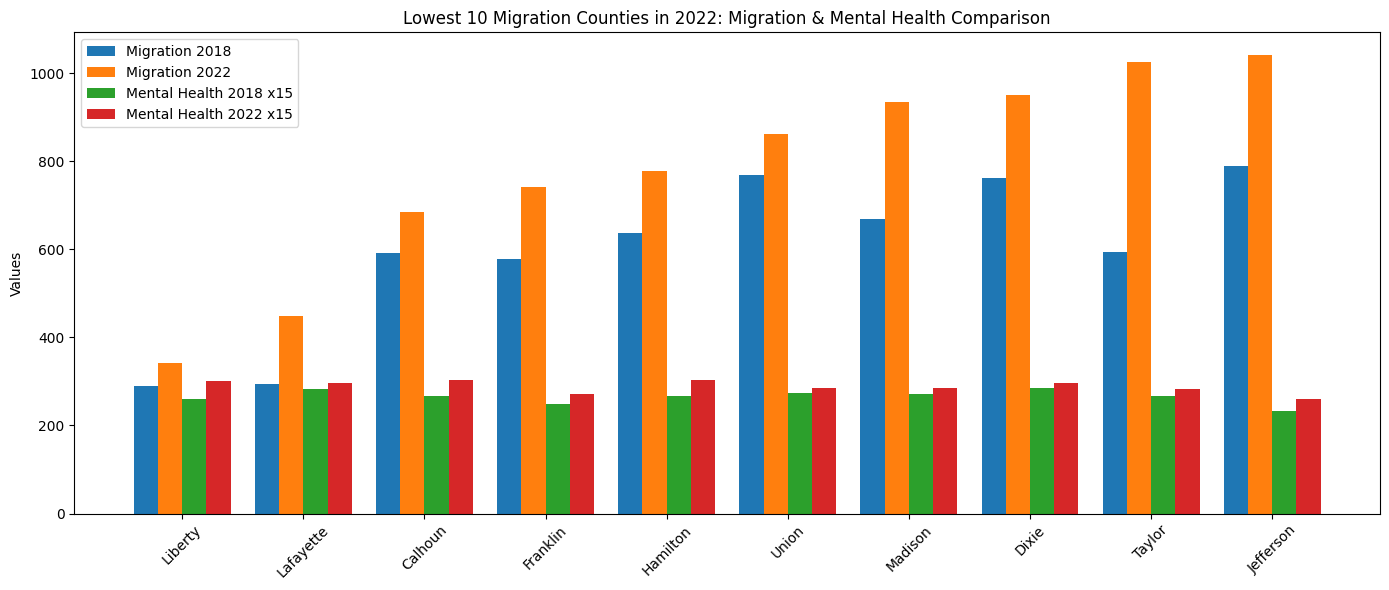

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Pick 10 lowest migration counties in 2022
lowest_2022 = merged_all_years.nsmallest(10, "total_migration_2122")

counties = lowest_2022["county_name"]
x = np.arange(len(counties))
width = 0.2  

# Scale mental health for visualization
scale_factor = 15  # adjust so bars are visible compared to migration
mh_18_scaled = lowest_2022["mental_health_18"] * scale_factor
mh_22_scaled = lowest_2022["mental_health_22"] * scale_factor

fig, ax = plt.subplots(figsize=(14,6))

# Bars
ax.bar(x - 1.5*width, lowest_2022["total_migration_1718"], width, label="Migration 2018", color="#1f77b4")
ax.bar(x - 0.5*width, lowest_2022["total_migration_2122"], width, label="Migration 2022", color="#ff7f0e")
ax.bar(x + 0.5*width, mh_18_scaled, width, label=f"Mental Health 2018 x{scale_factor}", color="#2ca02c")
ax.bar(x + 1.5*width, mh_22_scaled, width, label=f"Mental Health 2022 x{scale_factor}", color="#d62728")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45)
ax.set_ylabel("Values")
ax.set_title("Lowest 10 Migration Counties in 2022: Migration & Mental Health Comparison")
ax.legend()

plt.tight_layout()
plt.show()


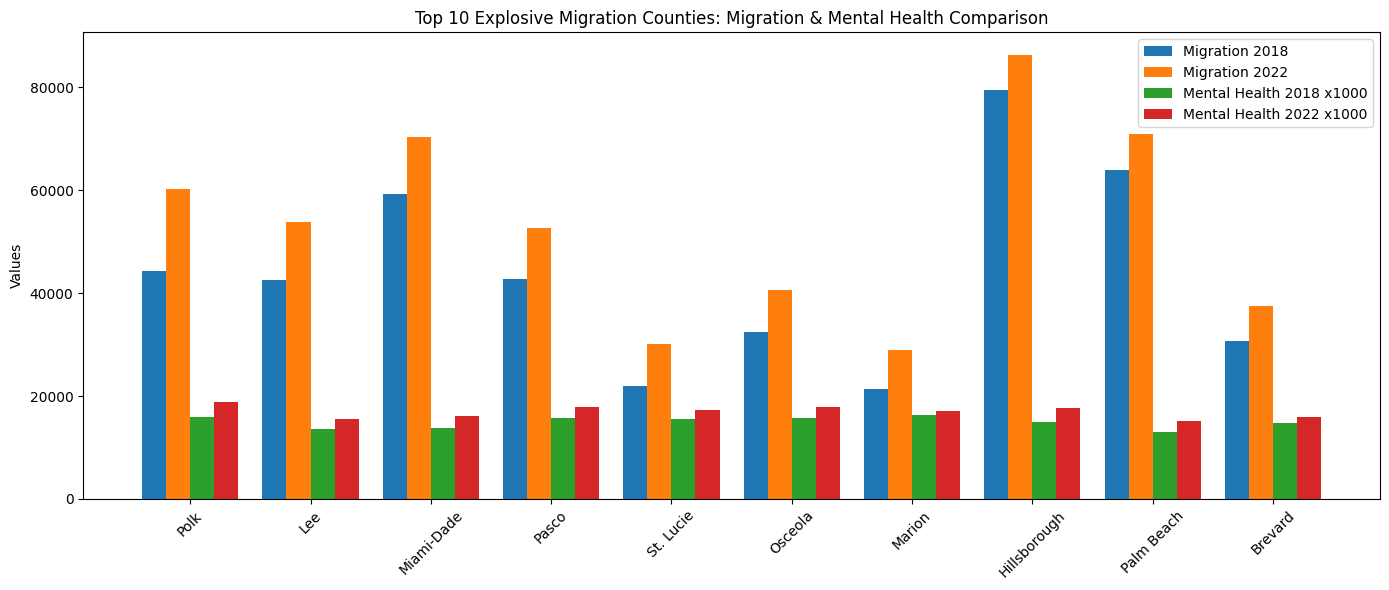

In [12]:
# See explosive migration

merged_all_years["migration_diff"] = merged_all_years["total_migration_2122"] - merged_all_years["total_migration_1718"]

top10 = merged_all_years.nlargest(10, "migration_diff")

counties = top10["county_name"]
x = np.arange(len(counties))
width = 0.2

scale_factor = 1000
mh_18_scaled = top10["mental_health_18"] * scale_factor
mh_22_scaled = top10["mental_health_22"] * scale_factor

fig, ax = plt.subplots(figsize=(14,6))

ax.bar(x - 1.5*width, top10["total_migration_1718"], width, label="Migration 2018", color="#1f77b4")
ax.bar(x - 0.5*width, top10["total_migration_2122"], width, label="Migration 2022", color="#ff7f0e")
ax.bar(x + 0.5*width, mh_18_scaled, width, label=f"Mental Health 2018 x{scale_factor}", color="#2ca02c")
ax.bar(x + 1.5*width, mh_22_scaled, width, label=f"Mental Health 2022 x{scale_factor}", color="#d62728")

ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45)
ax.set_ylabel("Values")
ax.set_title("Top 10 Explosive Migration Counties: Migration & Mental Health Comparison")
ax.legend()

plt.tight_layout()
plt.show()


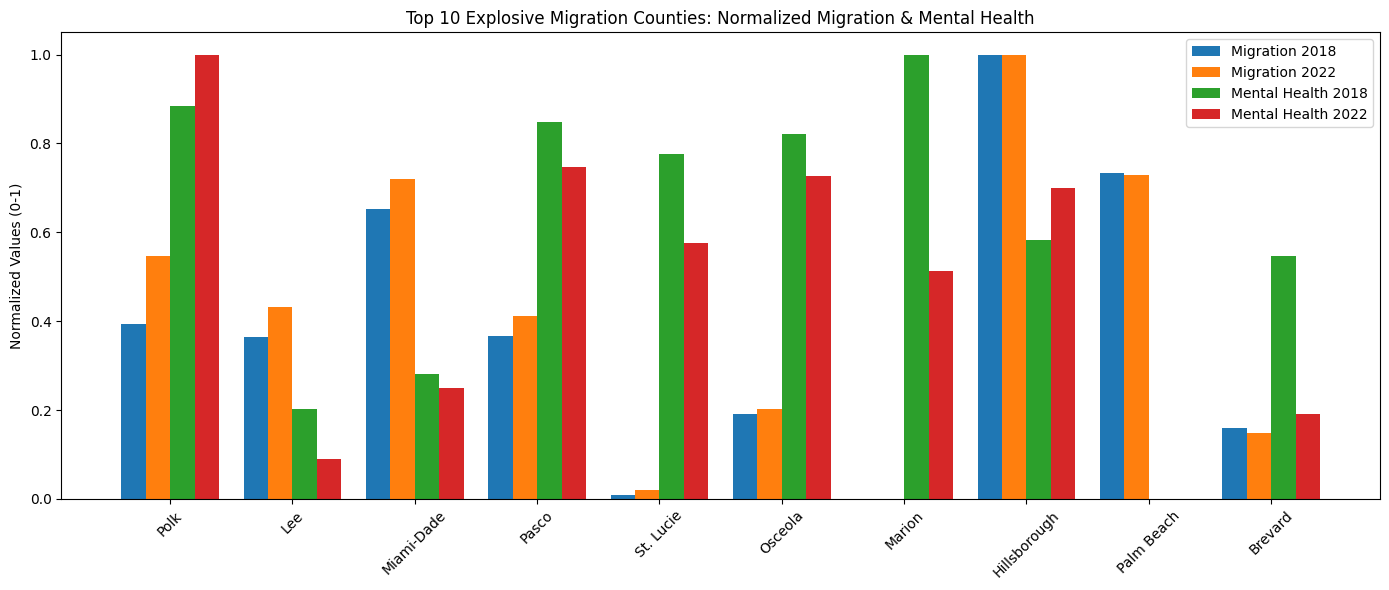

In [13]:
# scaling it to 0-1

merged_all_years["migration_diff"] = merged_all_years["total_migration_2122"] - merged_all_years["total_migration_1718"]

top10 = merged_all_years.nlargest(10, "migration_diff")

# Min-max scaling function
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize all 4 columns
migration_1718_scaled = min_max_scale(top10["total_migration_1718"])
migration_2122_scaled = min_max_scale(top10["total_migration_2122"])
mh_18_scaled = min_max_scale(top10["mental_health_18"])
mh_22_scaled = min_max_scale(top10["mental_health_22"])

counties = top10["county_name"]
x = np.arange(len(counties))
width = 0.2

fig, ax = plt.subplots(figsize=(14,6))

ax.bar(x - 1.5*width, migration_1718_scaled, width, label="Migration 2018", color="#1f77b4")
ax.bar(x - 0.5*width, migration_2122_scaled, width, label="Migration 2022", color="#ff7f0e")
ax.bar(x + 0.5*width, mh_18_scaled, width, label="Mental Health 2018", color="#2ca02c")
ax.bar(x + 1.5*width, mh_22_scaled, width, label="Mental Health 2022", color="#d62728")

ax.set_xticks(x)
ax.set_xticklabels(counties, rotation=45)
ax.set_ylabel("Normalized Values (0-1)")
ax.set_title("Top 10 Explosive Migration Counties: Normalized Migration & Mental Health")
ax.legend()

plt.tight_layout()
plt.show()


In [14]:
merged_all_years

,county_name,county_code,total_migration_1718,non_migrants_1718,mental_health_18,total_migration_2122,non_migrants_2122,mental_health_22,migration_diff
0,Alachua,1.0,13249,166305,16.505357,14706,171600,19.410345,1457
1,Baker,3.0,1384,18658,17.200000,1530,20446,19.450000,146
2,Bay,5.0,10546,127285,16.893023,13183,128940,18.302041,2637
3,Bradford,7.0,1441,16672,17.900000,1748,17315,19.233333,307
4,Brevard,9.0,30739,437221,14.757658,37471,465504,15.899306,6732
...,...,...,...,...,...,...,...,...,...
62,Union,125.0,768,7920,18.300000,862,8554,19.075000,94
63,Volusia,127.0,30872,376299,15.130088,36830,405864,17.020930,5958
64,Wakulla,129.0,2055,21879,15.750000,2518,24300,17.825000,463
65,Walton,131.0,6896,46888,16.245455,7688,56693,16.540000,792


In [15]:
merged_all_years['mental_health_22'].min()

13.55185185185185

In [16]:
# for all 67 counties, diff in mental health and % diff in migration!


In [17]:
merged_all_years.columns

Index(['county_name', 'county_code', 'total_migration_1718',
       'non_migrants_1718', 'mental_health_18', 'total_migration_2122',
       'non_migrants_2122', 'mental_health_22', 'migration_diff'],
      dtype='object')

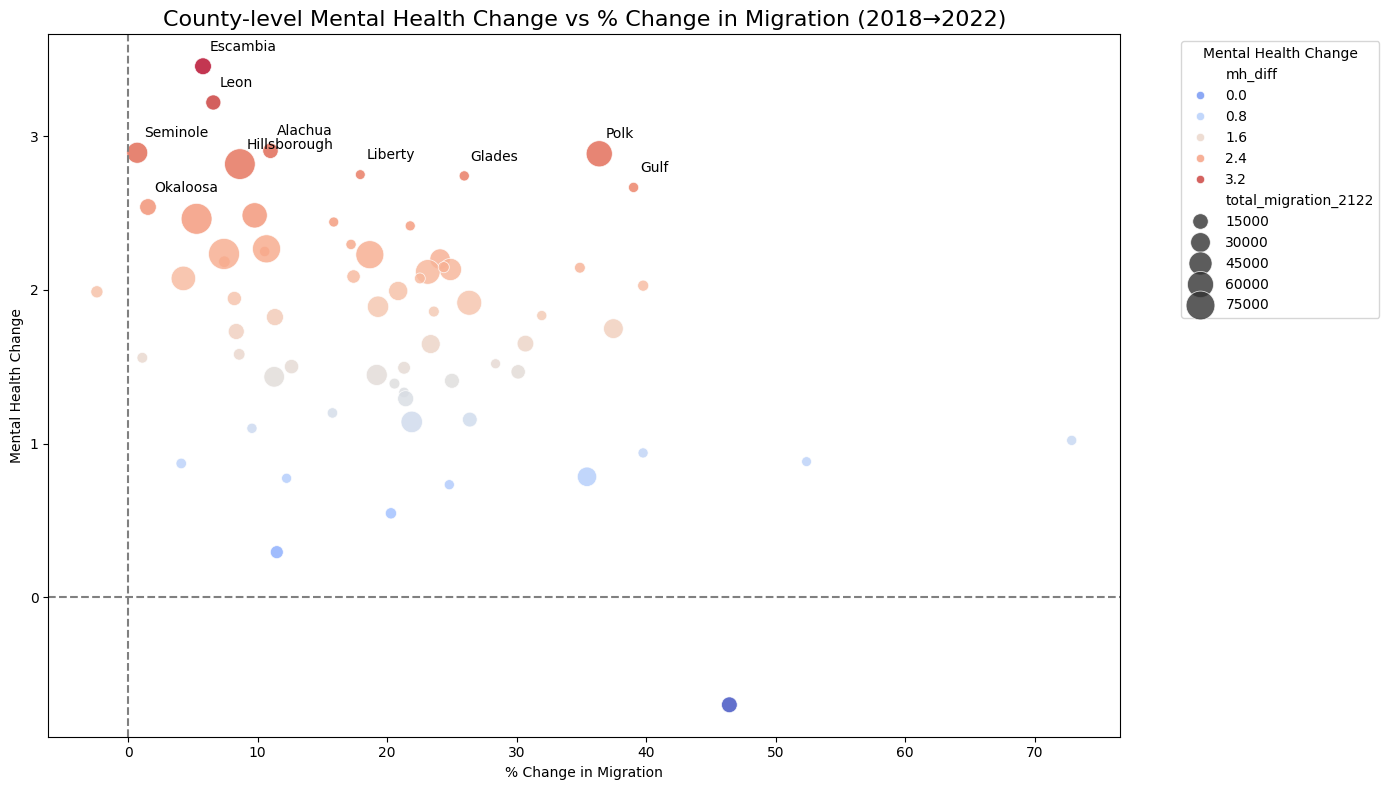

In [ ]:
# Compute difference and % change
merged_all_years['mh_diff'] = merged_all_years['mental_health_22'] - merged_all_years['mental_health_18']
merged_all_years['migration_pct_diff'] = (merged_all_years['total_migration_2122'] - merged_all_years['total_migration_1718']) / merged_all_years['total_migration_1718'] * 100

plt.figure(figsize=(14,8))
scatter = sns.scatterplot(
    data=merged_all_years,
    x='migration_pct_diff',
    y='mh_diff',
    size='total_migration_2122',
    hue='mh_diff',
    palette='coolwarm',
    sizes=(50, 500),
    alpha=0.8
)

# Add reference lines at 0
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

plt.title("County-level Mental Health Change vs % Change in Migration (2018→2022)", fontsize=16)
plt.xlabel("% Change in Migration")
plt.ylabel("Mental Health Change")
plt.legend(title="Mental Health Change", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Optional: label top 5 largest changes
top5 = merged_all_years.nlargest(10, 'mh_diff')
for i, row in top5.iterrows():
    plt.text(row['migration_pct_diff']+0.5, row['mh_diff']+0.1, row['county_name'], fontsize=10)

plt.show()


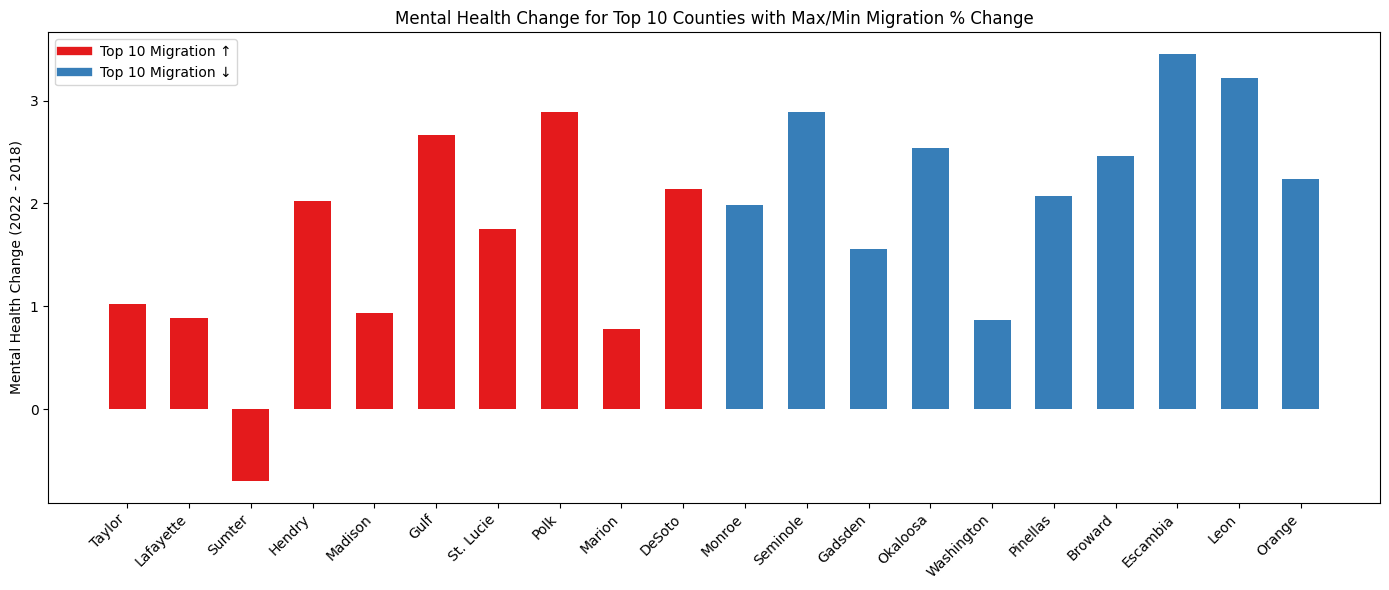

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Top 10 counties with highest migration % change
top10_mig = merged_all_years.nlargest(10, 'migration_pct_diff').copy()
top10_mig['group'] = 'Top 10 Migration ↑'

# Top 10 counties with lowest migration % change
bottom10_mig = merged_all_years.nsmallest(10, 'migration_pct_diff').copy()
bottom10_mig['group'] = 'Top 10 Migration ↓'

# Combine for plotting
plot_df = pd.concat([top10_mig, bottom10_mig], axis=0)

# Set positions for side-by-side bars
x = np.arange(len(plot_df['county_name']))
width = 0.4

fig, ax = plt.subplots(figsize=(14,6))

# Mental health change bars
colors = ['#e41a1c' if g=='Top 10 Migration ↑' else '#377eb8' for g in plot_df['group']]
ax.bar(plot_df['county_name'], plot_df['mh_diff'], color=colors, width=0.6)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Mental Health Change (2022 - 2018)')
plt.title('Mental Health Change for Top 10 Counties with Max/Min Migration % Change')
plt.legend(handles=[
    plt.Line2D([0], [0], color='#e41a1c', lw=6, label='Top 10 Migration ↑'),
    plt.Line2D([0], [0], color='#377eb8', lw=6, label='Top 10 Migration ↓')
])
plt.tight_layout()
plt.show()


In [ ]:
# doing  cut offs

In [ ]:

bins = [-np.inf, 0, 1, 3, 5, np.inf]  # adjust based on your data range
labels = ['Improved', 'Slight Worsening', 'Moderate Worsening', 'High Worsening', 'Severe Worsening']

merged_all_years['mh_category'] = pd.cut(merged_all_years['mh_diff'], bins=bins, labels=labels)




count    67.000000
mean      1.811252
std       0.738429
min      -0.698148
25%       1.399963
50%       1.890842
75%       2.242018
max       3.454659
Name: mh_diff, dtype: float64


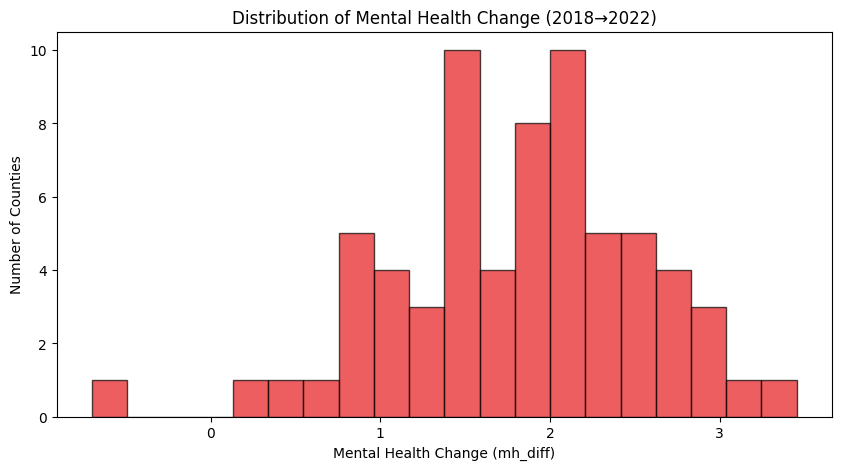

In [21]:
print(merged_all_years['mh_diff'].describe())

plt.figure(figsize=(10,5))
plt.hist(merged_all_years['mh_diff'], bins=20, color='#e41a1c', edgecolor='black', alpha=0.7)
plt.xlabel('Mental Health Change (mh_diff)')
plt.ylabel('Number of Counties')
plt.title('Distribution of Mental Health Change (2018→2022)')
plt.show()


In [22]:
merged_all_years['mh_category'].value_counts()


mh_category
High Worsening        29
Severe Worsening      29
Moderate Worsening     7
Improved               1
Slight Worsening       1
Name: count, dtype: int64